# Adding Model Predictions to Datasets

This recipe provides a glimpse into the possibilities for integrating FiftyOne into your machine learning workflows.

It covers the following concepts:

-   Loading your existing dataset in FiftyOne
-   Adding predictions from your model to your FiftyOne dataset
-   Launching the FiftyOne App and visualizing/exploring your data
-   Integrating the App into your data wrangling workflow

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

You'll also need to install `torch` and `torchvision`, if necessary:

In [1]:
!pip install torch torchvision

Download the test split of the CIFAR-10 dataset to `~/fiftyone/cifar10/test`:

In [2]:
# Downloads the test split of CIFAR-10
!fiftyone zoo datasets download cifar10 --splits test

Download a pretrained CIFAR-10 PyTorch model:

In [1]:
# Download the software
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10

# Download the pretrained model (90MB)
!eta gdrive download --public \
    1dGfpeFK_QG0kV-U6QDHMX2EOGXPqaNzu \
    PyTorch_CIFAR10/cifar10_models/state_dicts/resnet50.pt

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 613 (delta 23), reused 42 (delta 17), pack-reused 552
Receiving objects: 100% (613/613), 6.58 MiB | 3.34 MiB/s, done.
Resolving deltas: 100% (206/206), done.
 100% |████| 719.8Mb/719.8Mb [21.9s elapsed, 0s remaining, 28.4Mb/s]      


## Importing FiftyOne

Let's start by importing the FiftyOne library:

In [3]:
import fiftyone as fo

## Loading an image classification dataset

Suppose you have an image classification dataset on disk in the following
format:

```
<dataset_dir>/
    data/
        <uuid1>.<ext>
        <uuid2>.<ext>
        ...
    labels.json
```

where `labels.json` is a JSON file in the following format:

```
{
    "classes": [
        <labelA>,
        <labelB>,
        ...
    ],
    "labels": {
        <uuid1>: <target1>,
        <uuid2>: <target2>,
        ...
    }
}
```

In your current workflow, you may parse this data into a list of
`(image_path, label)` tuples as follows:

In [4]:
import json
import os

# The location of the dataset on disk that you downloaded above
dataset_dir = os.path.expanduser("~/fiftyone/cifar10/test")

# Maps image UUIDs to image paths
images_dir = os.path.join(dataset_dir, "data")
image_uuids_to_paths = {
    os.path.splitext(n)[0]: os.path.join(images_dir, n)
    for n in os.listdir(images_dir)
}

labels_path = os.path.join(dataset_dir, "labels.json")
with open(labels_path, "rt") as f:
    _labels = json.load(f)

# Get classes
classes = _labels["classes"]

# Maps image UUIDs to int targets
labels = _labels["labels"]

# Make a list of (image_path, label) samples
data = [(image_uuids_to_paths[u], classes[t]) for u, t in labels.items()]

# Print a few data
print(data[:5])

[('/home/ben/fiftyone/cifar10/test/data/00001.jpg', 'horse'), ('/home/ben/fiftyone/cifar10/test/data/00002.jpg', 'airplane'), ('/home/ben/fiftyone/cifar10/test/data/00003.jpg', 'frog'), ('/home/ben/fiftyone/cifar10/test/data/00004.jpg', 'truck'), ('/home/ben/fiftyone/cifar10/test/data/00005.jpg', 'dog')]


Building a FiftyOne dataset from your samples is simple:

In [5]:
# Load the data into FiftyOne samples
samples = []
for image_path, label in data:
    samples.append(
        fo.Sample(
            filepath=image_path,
            ground_truth=fo.Classification(label=label),
        )
    )

# Add the samples to a dataset
dataset = fo.Dataset("my-dataset")
dataset.add_samples(samples)

# Print some information about the dataset
print(dataset)

 100% |████| 10000/10000 [32.1s elapsed, 0s remaining, 321.7 samples/s]      
Name:           my-dataset
Media type:     image
Num samples:    10000
Persistent:     False
Info:           {}
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


In [5]:
# Print a few samples from the dataset
print(dataset.head())

[<Sample: {
    'id': '5ff8e4738f65fe3301637be7',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/00001.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8e4728f65fe33016354d6',
        'label': 'horse',
        'confidence': None,
        'logits': None,
    }>,
}>, <Sample: {
    'id': '5ff8e4738f65fe3301637be9',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/00002.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8e4728f65fe33016354d7',
        'label': 'airplane',
        'confidence': None,
        'logits': None,
    }>,
}>, <Sample: {
    'id': '5ff8e4738f65fe3301637beb',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/00003.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8e4728f65fe33016354d8',
   

## Working with views into your dataset

FiftyOne provides a powerful notion of _dataset views_ for you to access
subsets of the samples in your dataset.

Here's an example operation:

In [6]:
# Used to write view expressions that involve sample fields
from fiftyone import ViewField as F

# Gets five airplanes from the dataset
view = (
    dataset.match(F("ground_truth.label") == "airplane")
    .limit(5)
)

# Print some information about the view you created
print(view)

Dataset:        my-dataset
Media type:     image
Num samples:    5
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. Match(filter={'$expr': {'$eq': [...]}})
    2. Limit(limit=5)


In [7]:
# Print a few samples from the view
print(view.head())

[<SampleView: {
    'id': '5ff8f0de6f39ba18fc47193e',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/00002.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8f0dd6f39ba18fc46f22c',
        'label': 'airplane',
        'confidence': None,
        'logits': None,
    }>,
}>, <SampleView: {
    'id': '5ff8f0de6f39ba18fc47194a',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/00008.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8f0dd6f39ba18fc46f232',
        'label': 'airplane',
        'confidence': None,
        'logits': None,
    }>,
}>, <SampleView: {
    'id': '5ff8f0df6f39ba18fc47196c',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/00025.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8f0dd6f39ba1

Iterating over the samples in a view is easy:

In [8]:
for sample in view:
    print(sample.filepath)

/home/ben/fiftyone/cifar10/test/data/00002.jpg
/home/ben/fiftyone/cifar10/test/data/00008.jpg
/home/ben/fiftyone/cifar10/test/data/00025.jpg
/home/ben/fiftyone/cifar10/test/data/00026.jpg
/home/ben/fiftyone/cifar10/test/data/00032.jpg


## Adding model predictions to your dataset

The following code demonstrates how to add predictions from a model to your
FiftyOne dataset, with minimal changes to your existing ML code:

In [9]:
import sys

import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader

import fiftyone.utils.torch as fout

sys.path.insert(1, "PyTorch_CIFAR10")
from cifar10_models import *


def make_cifar10_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)


def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences


#
# Load a model
#
# Model performance numbers are available at:
#   https://github.com/huyvnphan/PyTorch_CIFAR10
#

model = resnet50(pretrained=True)
model_name = "resnet50"

#
# Extract a few images to process
#

num_samples = 25
batch_size = 5

view = dataset.take(num_samples)

image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in view])
data_loader = make_cifar10_data_loader(image_paths, sample_ids, batch_size)

#
# Perform prediction and store results in dataset
#

for imgs, sample_ids in data_loader:
    predictions, confidences = predict(model, imgs)

    # Add predictions to your FiftyOne dataset
    for sample_id, prediction, confidence in zip(
        sample_ids, predictions, confidences
    ):
        sample = dataset[sample_id]
        sample[model_name] = fo.Classification(
            label=classes[prediction],
            confidence=confidence,
        )
        sample.save()

#
# Print the last batch of samples for which we added predictions
#

last_batch = dataset.select(sample_ids)
print(last_batch.head(batch_size))

[<SampleView: {
    'id': '5ff8f0eb6f39ba18fc473678',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/03743.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8f0de6f39ba18fc4700c9',
        'label': 'ship',
        'confidence': None,
        'logits': None,
    }>,
    'resnet50': <Classification: {
        'id': '5ff8f10b6f39ba18fc4767aa',
        'label': 'ship',
        'confidence': 0.7454119920730591,
        'logits': None,
    }>,
}>, <SampleView: {
    'id': '5ff8f0ec6f39ba18fc47397a',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/04128.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8f0de6f39ba18fc47024a',
        'label': 'truck',
        'confidence': None,
        'logits': None,
    }>,
    'resnet50': <Classification: {
        'id': '5ff8f10b6f39ba18fc4767ac',
        'label': 'cat

In [13]:
#
# Get all samples for which we added predictions, in reverse order of
# confidence
#
pred_view = (
    dataset
    .exists(model_name)
    .sort_by("%s.confidence" % model_name, reverse=True)
)

print("Number of samples: %s\n" % len(pred_view))
print(pred_view.head())

Number of samples: 25

[<SampleView: {
    'id': '5ff8f0f56f39ba18fc475110',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/07147.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8f0de6f39ba18fc470e15',
        'label': 'automobile',
        'confidence': None,
        'logits': None,
    }>,
    'resnet50': <Classification: {
        'id': '5ff8f10b6f39ba18fc4767a6',
        'label': 'automobile',
        'confidence': 0.844084620475769,
        'logits': None,
    }>,
}>, <SampleView: {
    'id': '5ff8f0e46f39ba18fc4725b4',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/01597.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8f0de6f39ba18fc46f867',
        'label': 'automobile',
        'confidence': None,
        'logits': None,
    }>,
    'resnet50': <Classification: {
        'id': '5ff8f10a6

## Using the FiftyOne App

FiftyOne provides a powerful App that allows you easily visualize,
explore, search, filter, your datasets.

You can explore the App interactively through the GUI, and you can even
interact with it in real-time from your Python interpreter!


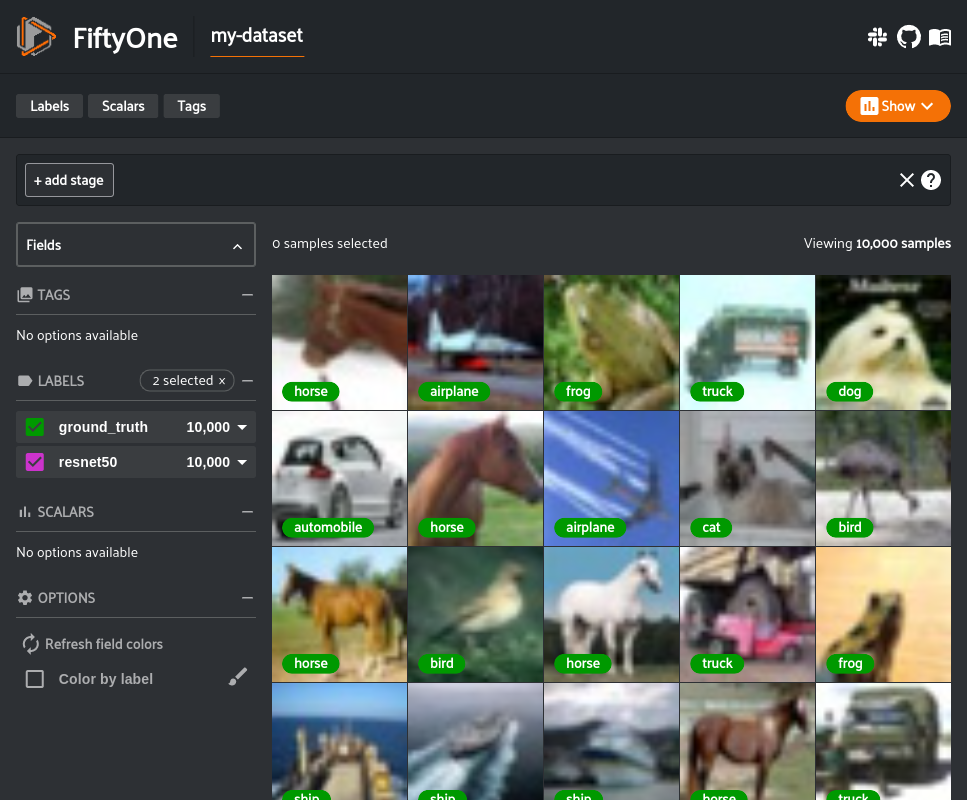

In [10]:
# Open the dataset in the App
session = fo.launch_app(dataset)


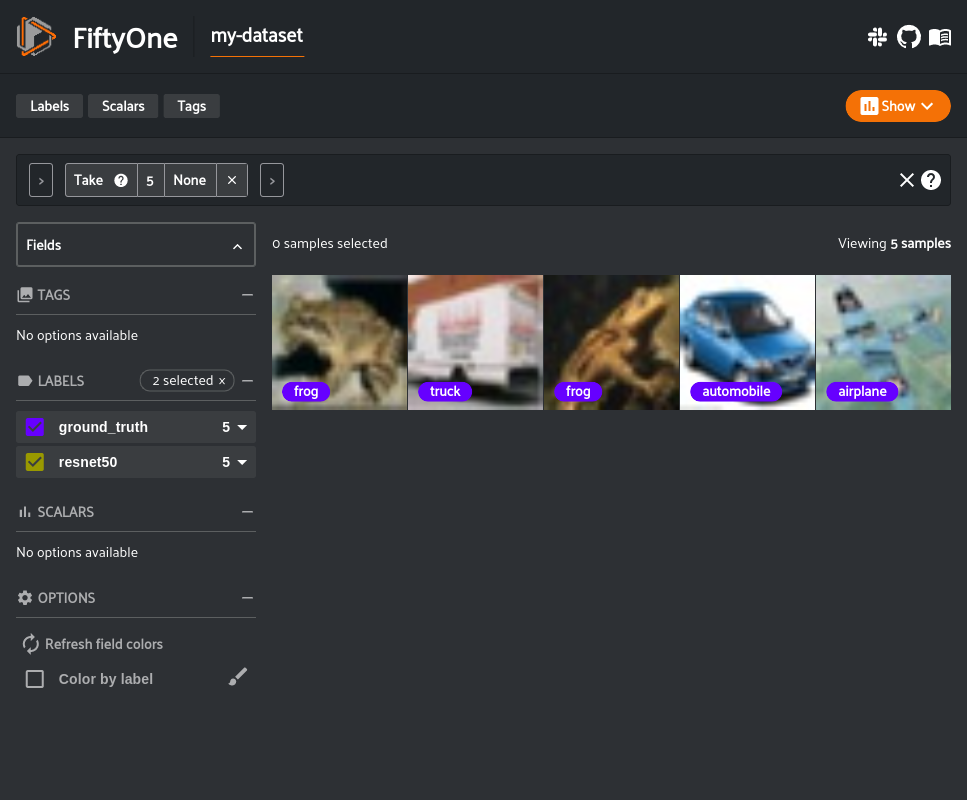

In [11]:
# Show five random samples in the App
session.view = dataset.take(5)


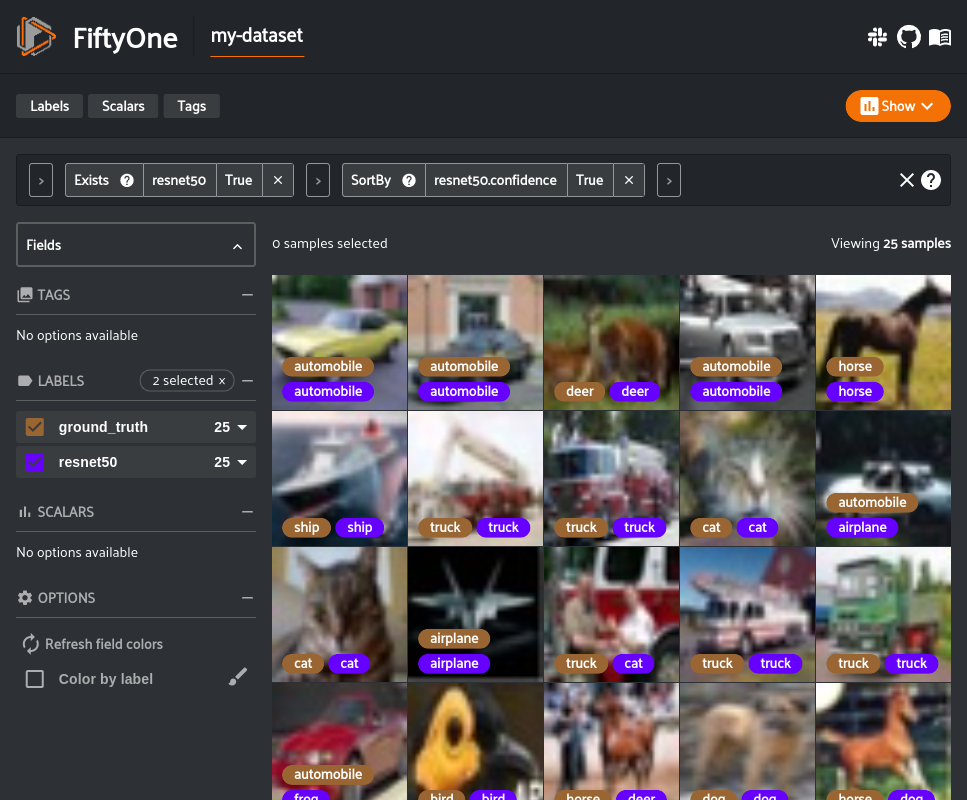

In [14]:
# Show the samples for which we added predictions above
session.view = pred_view


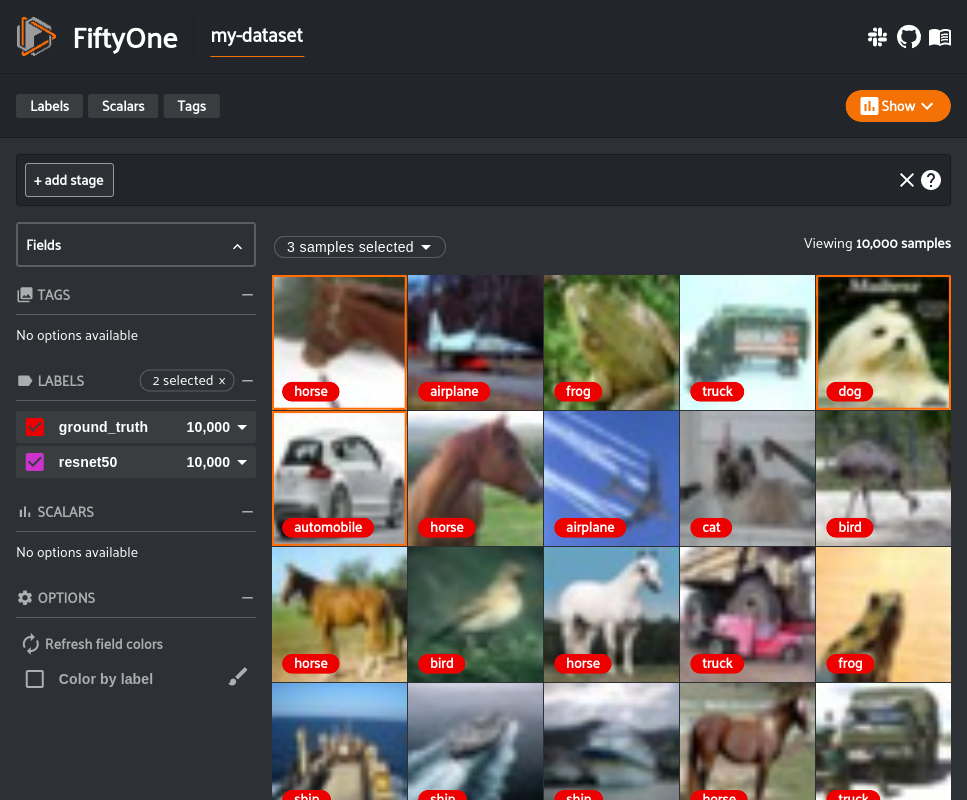

In [15]:
# Show the full dataset again
session.view = None

You can select images in the App by clicking on them. Then, you can hop back over to the library and make a view that contains those samples!

In [16]:
# Make a view containing the currently selected samples in the App
selected_view = dataset.select(session.selected)

# Print details about the selected samples
print(selected_view)
print(selected_view.head())

Dataset:        my-dataset
Media type:     image
Num samples:    3
Tags:           []
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    resnet50:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. Select(sample_ids=['5ff8f0de6f39ba18fc47193c', '5ff8f0de6f39ba18fc471944', '5ff8f0de6f39ba18fc471946'])
[<SampleView: {
    'id': '5ff8f0de6f39ba18fc47193c',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/00001.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff8f0dd6f39ba18fc46f22b',
        'label': 'horse',
        'confidence': None,
        'logits': Non

In [17]:
session.freeze() # screenshot the active App for sharing